Saving Churn_Modelling_clean_csv.csv to Churn_Modelling_clean_csv (11).csv
Archivo cargado: Churn_Modelling_clean_csv (11).csv
Datos cargados con éxito!
   CreditScore Geography  Gender   Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female  42.0       2       0.00              1   
1          608     Spain  Female  41.0       1   83807.86              1   
2          502    France  Female  42.0       8  159660.80              3   
3          699    France  Female  39.0       1       0.00              2   
4          850     Spain  Female  43.0       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0        1.0             1.0        101348.88       1  
1        0.0             1.0        112542.58       0  
2        1.0             0.0        113931.57       1  
3        0.0             0.0         93826.63       0  
4        NaN             1.0         79084.10       0  

Valores nulos antes de limpieza:
CreditScore        0

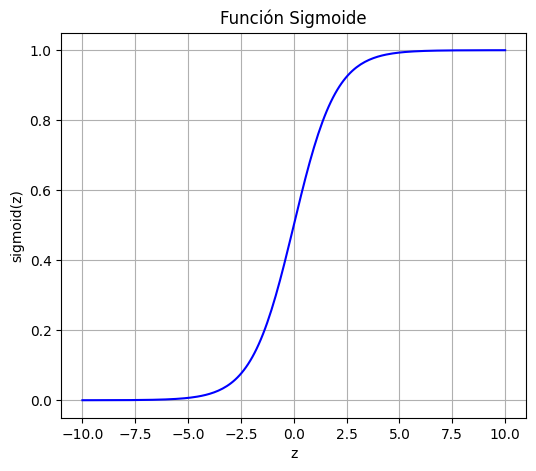


Ejemplo de primeras 10 probabilidades calculadas con la sigmoide:
[0.06128617 0.07257685 0.30730565 0.41321809 0.06545211 0.265235
 0.26222673 0.02950915 0.04638102 0.30028083]

=== MÉTRICAS ===
Accuracy: 0.809095452273863

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      1599
           1       0.57      0.21      0.31       402

    accuracy                           0.81      2001
   macro avg       0.70      0.59      0.60      2001
weighted avg       0.78      0.81      0.77      2001



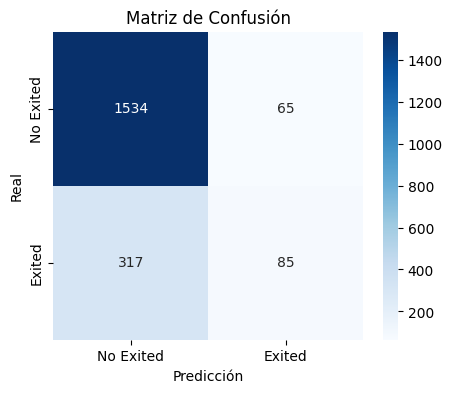

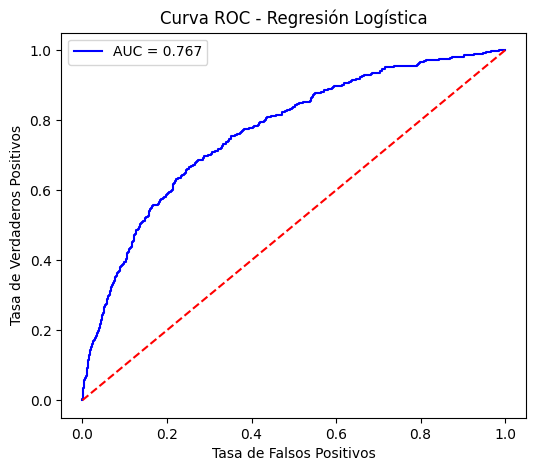

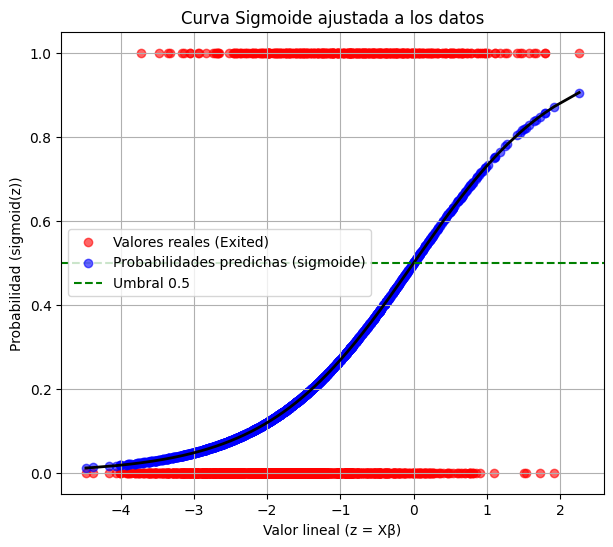

In [28]:
# ===============================
# REGRESIÓN LOGÍSTICA + SIGMOIDE
# ===============================

# 1. Importar librerías
import pandas as pd
import numpy as np
from google.colab import files
import io

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns

# 2. Subir archivo CSV
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print("Archivo cargado:", filename)

df = pd.read_csv(io.BytesIO(uploaded[filename]))
print("Datos cargados con éxito!")
print(df.head())

# 3. Verificar valores nulos
print("\nValores nulos antes de limpieza:")
print(df.isnull().sum())

# Rellenar NaN numéricos con media y categóricos con moda
for col in df.columns:
    if df[col].dtype in ['float64','int64']:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Confirmar limpieza
print("\nValores nulos después de limpieza:")
print(df.isnull().sum())

# 4. Variables dependiente (y) e independientes (X)
X = df.drop("Exited", axis=1)   # Features
y = df["Exited"]                # Target

# Codificación de variables categóricas
X = pd.get_dummies(X, drop_first=True)

# 5. Dividir dataset en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Entrenar modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# 8. Predicciones
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:,1]

# ===============================
# FUNCIÓN SIGMOIDE
# ===============================

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Ejemplo: graficar la función sigmoide en un rango
z = np.linspace(-10, 10, 200)
sig = sigmoid(z)

plt.figure(figsize=(6,5))
plt.plot(z, sig, color="blue")
plt.title("Función Sigmoide")
plt.xlabel("z")
plt.ylabel("sigmoid(z)")
plt.grid(True)
plt.show()

# Aplicar sigmoide a los valores de entrada del modelo
# (combinación lineal Xβ)
z_model = np.dot(X_test_scaled, log_reg.coef_.T) + log_reg.intercept_
y_sigmoid = sigmoid(z_model)

print("\nEjemplo de primeras 10 probabilidades calculadas con la sigmoide:")
print(y_sigmoid[:10].flatten())

# ===============================
# EVALUACIÓN DEL MODELO
# ===============================

print("\n=== MÉTRICAS ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Exited","Exited"], yticklabels=["No Exited","Exited"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="red", linestyle="--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Regresión Logística")
plt.legend()
plt.show()

# ===============================
# GRAFICAR SIGMOIDE CON DATOS REALES
# ===============================

# Calcular z (combinación lineal de características y coeficientes del modelo)
z_model = np.dot(X_test_scaled, log_reg.coef_.T) + log_reg.intercept_

# Aplicar sigmoide para obtener probabilidades
y_sigmoid = sigmoid(z_model)

# Graficar: eje x = z_model, eje y = probabilidades
plt.figure(figsize=(7,6))
plt.scatter(z_model, y_test, color="red", label="Valores reales (Exited)", alpha=0.6)
plt.scatter(z_model, y_sigmoid, color="blue", label="Probabilidades predichas (sigmoide)", alpha=0.6)

# Ordenar puntos para que se vea la curva más limpia
sorted_idx = np.argsort(z_model.flatten())
plt.plot(z_model.flatten()[sorted_idx], y_sigmoid.flatten()[sorted_idx], color="black", linewidth=2)

plt.axhline(0.5, color="green", linestyle="--", label="Umbral 0.5")
plt.xlabel("Valor lineal (z = Xβ)")
plt.ylabel("Probabilidad (sigmoid(z))")
plt.title("Curva Sigmoide ajustada a los datos")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from google.colab import files
uploaded = files.upload()


Saving Churn_Modelling_clean_csv.csv to Churn_Modelling_clean_csv (6).csv
